## Shortening context by message trimming

In [13]:
from configs import API_KEY, DEFAULT_MODEL
import os
import openai
from langgraph.graph import START, END, StateGraph, add_messages,MessagesState
from typing_extensions import TypedDict
from langchain_openai.chat_models import ChatOpenAI
from langchain_core.messages import AIMessage,HumanMessage, BaseMessage, RemoveMessage
from langchain_core.runnables import Runnable 
from collections.abc import Sequence
from typing import Literal, Annotated

In [3]:
os.environ["OPENAI_API_KEY"] = API_KEY
openai.api_key = os.getenv('OPENAI_API_KEY')

In [10]:
my_list = add_messages([AIMessage("What is your question?"),
                        HumanMessage("when did Titanic release?"),
                        AIMessage("The movie was released on December 19, 1997 in the United States."),
                        AIMessage("Would you like to ask one more question (yes/no)?"),
                        HumanMessage("yes"),
                        AIMessage("What is your question?"),
                        HumanMessage("who played the main character?"),
                        AIMessage("The main characters were played by Leonardo DiCaprio and Kate Winslet."),
                        AIMessage("Would you like to ask one more question (yes/no)?")],
                       [HumanMessage("no")])

In [11]:
my_list

[AIMessage(content='What is your question?', additional_kwargs={}, response_metadata={}, id='a387a551-3e5b-428b-9370-58f57880f89d', tool_calls=[], invalid_tool_calls=[]),
 HumanMessage(content='when did Titanic release?', additional_kwargs={}, response_metadata={}, id='574acd49-d208-44da-bb18-95c3a772e5c7'),
 AIMessage(content='The movie was released on December 19, 1997 in the United States.', additional_kwargs={}, response_metadata={}, id='df520da8-0a76-4e7b-849e-ef2e8b469549', tool_calls=[], invalid_tool_calls=[]),
 AIMessage(content='Would you like to ask one more question (yes/no)?', additional_kwargs={}, response_metadata={}, id='cc5e6895-1428-4c83-be0a-a158e4a10a1c', tool_calls=[], invalid_tool_calls=[]),
 HumanMessage(content='yes', additional_kwargs={}, response_metadata={}, id='4cfcf076-3fd1-4a56-ab18-517ea1ddd5c7'),
 AIMessage(content='What is your question?', additional_kwargs={}, response_metadata={}, id='5991eff0-4c6d-445c-b084-ec6d1f8ecbb7', tool_calls=[], invalid_tool_c

In [14]:
remove_messages = [RemoveMessage(i.id) for i in my_list[:-5]]

In [15]:
remove_messages

[RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='a387a551-3e5b-428b-9370-58f57880f89d'),
 RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='574acd49-d208-44da-bb18-95c3a772e5c7'),
 RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='df520da8-0a76-4e7b-849e-ef2e8b469549'),
 RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='cc5e6895-1428-4c83-be0a-a158e4a10a1c'),
 RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='4cfcf076-3fd1-4a56-ab18-517ea1ddd5c7')]

In [16]:
add_messages(my_list, remove_messages)

[AIMessage(content='What is your question?', additional_kwargs={}, response_metadata={}, id='5991eff0-4c6d-445c-b084-ec6d1f8ecbb7', tool_calls=[], invalid_tool_calls=[]),
 HumanMessage(content='who played the main character?', additional_kwargs={}, response_metadata={}, id='8aba0ef8-3ab6-4bed-a7ab-cf7ee70eb93e'),
 AIMessage(content='The main characters were played by Leonardo DiCaprio and Kate Winslet.', additional_kwargs={}, response_metadata={}, id='05af436d-ae4f-4998-a324-6a8af05270fa', tool_calls=[], invalid_tool_calls=[]),
 AIMessage(content='Would you like to ask one more question (yes/no)?', additional_kwargs={}, response_metadata={}, id='dcb772f6-4d19-491f-97b6-190f698a2e26', tool_calls=[], invalid_tool_calls=[]),
 HumanMessage(content='no', additional_kwargs={}, response_metadata={}, id='294ac634-ce84-4f53-bfbe-04fd531af93b')]

In [4]:
chat = ChatOpenAI(model='gpt-4',
                 seed = 365,
                 temperature = 0,
                 max_completion_tokens = 100)

In [17]:
def ask_question(state: MessagesState) -> MessagesState:
    print("\n--------------> Entering Ask Question Node:")
    for i in state["messages"]:
        i.pretty_print()
    question = "What is your question?"
    print(question)
    return MessagesState(messages=[AIMessage(question), HumanMessage(input())])

def chatbot(state: MessagesState) -> MessagesState:
    print("\n--------------> Entering Chatbot:")
    
    for i in state["messages"]:
        i.pretty_print()
    response = chat.invoke(state['messages'])
    response.pretty_print()
    return MessagesState(messages=[response])
    
def ask_another_question(state: MessagesState) -> MessagesState:
    print("\n--------------> Entering Ask Another Question Node:")
    for i in state["messages"]:
        i.pretty_print()
    question = "Would you like to ask one more question (yes/no)?"
    print(question)
    return MessagesState(messages=[AIMessage(question), HumanMessage(input())])

def trim_messages(state: MessagesState) -> MessagesState:
    print("\n--------------> Entering trim_messages Node:")
    remove_messages = [RemoveMessage(i.id) for i in state["messages"][:-5]]
    return MessagesState(messages = remove_messages)

In [18]:
def routing_function(state: MessagesState) -> Literal["trim_messages","__end__"] :
    if state["messages"][-1].content == "yes":
        return "trim_messages"
    else:
        return "__end__"

In [21]:
graph_ms = StateGraph(MessagesState)
graph_ms.add_node("ask_question", ask_question)
graph_ms.add_node("chatbot", chatbot)
graph_ms.add_node("ask_another_question", ask_another_question)
graph_ms.add_node("trim_messages", trim_messages)

graph_ms.add_edge(START, "ask_question")
graph_ms.add_edge("ask_question", "chatbot")
graph_ms.add_edge("chatbot", "ask_another_question")
graph_ms.add_conditional_edges(source = "ask_another_question", 
                            path = routing_function,)
graph_ms.add_edge("trim_messages", "ask_question")

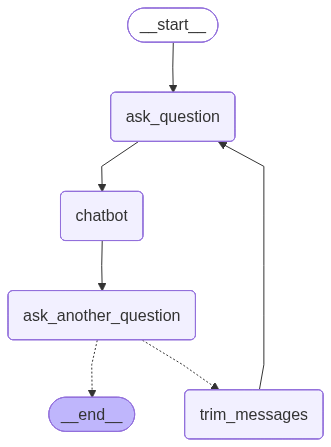

In [22]:
graph_ms_compiled = graph_ms.compile()
graph_ms_compiled

In [27]:
graph_ms_compiled.invoke(MessagesState(messages=[]))


--------------> Entering Ask Question Node:
What is your question?


 who was the creator of illuminati?



--------------> Entering Chatbot:
================================== Ai Message ==================================

What is your question?
================================ Human Message =================================

who was the creator of illuminati?
================================== Ai Message ==================================

The Illuminati was created by Professor Adam Weishaupt in 1776. He was a German philosopher and a professor of Canon Law at the University of Ingolstadt.

--------------> Entering Ask Another Question Node:
================================== Ai Message ==================================

What is your question?
================================ Human Message =================================

who was the creator of illuminati?
================================== Ai Message ==================================

The Illuminati was created by Professor Adam Weishaupt in 1776. He was a German philosopher and a professor of Canon Law at the University of Ingolsta

 yes



--------------> Entering trim_messages Node:

--------------> Entering Ask Question Node:
================================== Ai Message ==================================

What is your question?
================================ Human Message =================================

who was the creator of illuminati?
================================== Ai Message ==================================

The Illuminati was created by Professor Adam Weishaupt in 1776. He was a German philosopher and a professor of Canon Law at the University of Ingolstadt.
================================== Ai Message ==================================

Would you like to ask one more question (yes/no)?
================================ Human Message =================================

yes
What is your question?


 who was he?



--------------> Entering Chatbot:
================================== Ai Message ==================================

What is your question?
================================ Human Message =================================

who was the creator of illuminati?
================================== Ai Message ==================================

The Illuminati was created by Professor Adam Weishaupt in 1776. He was a German philosopher and a professor of Canon Law at the University of Ingolstadt.
================================== Ai Message ==================================

Would you like to ask one more question (yes/no)?
================================ Human Message =================================

yes
================================== Ai Message ==================================

What is your question?
================================ Human Message =================================

who was he?
================================== Ai Message ==================================

Adam Wei

 yes



--------------> Entering trim_messages Node:

--------------> Entering Ask Question Node:
================================== Ai Message ==================================

What is your question?
================================ Human Message =================================

who was he?
================================== Ai Message ==================================

Adam Weishaupt was a German philosopher and professor. He was born on February 6, 1748, in Ingolstadt, Bavaria, Germany. After his father's death, he was raised by his godfather, Johann Adam Freiherr von Ickstatt, who influenced Weishaupt with his Enlightenment philosophy. 

Weishaupt became a professor of law at the University of Ingolstadt in 1772, and later a professor of canon law. He was the first
================================== Ai Message ==================================

Would you like to ask one more question (yes/no)?
================================ Human Message =================================

yes
What

 what was that philosophy about?



--------------> Entering Chatbot:
================================== Ai Message ==================================

What is your question?
================================ Human Message =================================

who was he?
================================== Ai Message ==================================

Adam Weishaupt was a German philosopher and professor. He was born on February 6, 1748, in Ingolstadt, Bavaria, Germany. After his father's death, he was raised by his godfather, Johann Adam Freiherr von Ickstatt, who influenced Weishaupt with his Enlightenment philosophy. 

Weishaupt became a professor of law at the University of Ingolstadt in 1772, and later a professor of canon law. He was the first
================================== Ai Message ==================================

Would you like to ask one more question (yes/no)?
================================ Human Message =================================

yes
================================== Ai Message ==============

 no


{'messages': [AIMessage(content='What is your question?', additional_kwargs={}, response_metadata={}, id='b2719dcc-5152-4eb1-ac20-6eaecf5cad3a', tool_calls=[], invalid_tool_calls=[]),
  HumanMessage(content='who was he?', additional_kwargs={}, response_metadata={}, id='1ddfa48e-292c-43bd-9d27-49947ee8f52b'),
  AIMessage(content="Adam Weishaupt was a German philosopher and professor. He was born on February 6, 1748, in Ingolstadt, Bavaria, Germany. After his father's death, he was raised by his godfather, Johann Adam Freiherr von Ickstatt, who influenced Weishaupt with his Enlightenment philosophy. \n\nWeishaupt became a professor of law at the University of Ingolstadt in 1772, and later a professor of canon law. He was the first", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 100, 'prompt_tokens': 101, 'total_tokens': 201, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_pre